Welcome! This is our text-to-image model. We have specified in the following the cells to be run in order to test the trained model with new images.

In [7]:
# RUN THIS CELL
## Install Necessary Libraries
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0
!pip install git+https://github.com/huggingface/diffusers
!pip install torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-zblte1d0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-zblte1d0
  Resolved https://github.com/huggingface/diffusers to commit 08b453e3828f80027d881bb460716af95e192bcd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.25.0.dev0-py3

In [8]:
# RUN THIS CELL
## Import Libraries
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import os
import pathlib
import cv2
from huggingface_hub import notebook_login
from diffusers import DiffusionPipeline, StableDiffusionPipeline
from datasets import load_dataset, Dataset
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from torchvision.transforms import functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Mounted at /content/drive


In [ ]:
## Login to HuggingFace
notebook_login()

# Data Pre-Processing

In this section, we loaded the WikiArt dataset (Artificio/WikiArt (n.d.)) and checked its structure. Starting from the original dataset, we created a new one including Van Gogh's paintings only and reporting for each image its relative description. This dataset was saved as "van_gogh_data".

References:

Artificio/WikiArt (n.d.). Hugging Face. https://huggingface.co/datasets/Artificio/WikiArt

In [ ]:
# Load the WikiArt Dataset
art_data = load_dataset("Artificio/WikiArt")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/103250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512'],
        num_rows: 103250
    })
})
John French Sloan / Cornelia Street / New Realism / cityscape / 1920


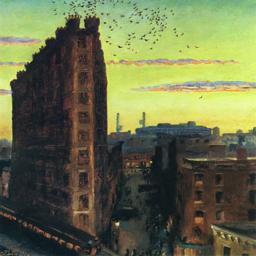

In [ ]:
# Check that the Dataset Loaded Apporpriately
print(art_data)

# Load one of the Images and Description
print(art_data['train'][0]['description'])
display(art_data['train'][0]['image'])

In [ ]:
# Print one of the Artist
print(art_data['train'][0]['artist'])

John French Sloan


In [ ]:
# Due to the Size of the Dataset, Specific Artists will be Extracted to Use for Final Fine-Tuning
vincent_subset = art_data.filter(lambda example: example["artist"].lower() == "vincent van gogh")

Filter:   0%|          | 0/103250 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512'],
        num_rows: 494
    })
})
Vincent van Gogh / Head of a Young Peasant Woman with Dark Cap / Realism / portrait / 1885


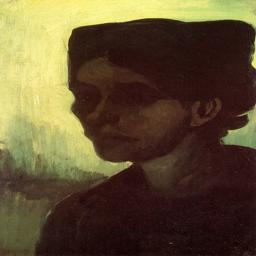

In [ ]:
# Check the Subset
print(vincent_subset)

# Display the First Image and Description
print(vincent_subset['train'][0]['description'])
display(vincent_subset['train'][0]['image'])

In [ ]:
# Create a Proper Image, Text Dataset for Model Fine-Tuning
# Extract Each Image and Store in Dataset
img_prompt = {'image': [], 'text':[]}
for img, prompt in zip(vincent_subset['train'][:]['image'], vincent_subset['train'][:]['description']):
  # Add the Image to the Dataset
  img_prompt['image'].append(img)

  # Edit the Prompt to Be More Human Readable
  img_prompt['text'].append(prompt.split('/')[1].strip())

Text: Head of a Young Peasant Woman with Dark Cap


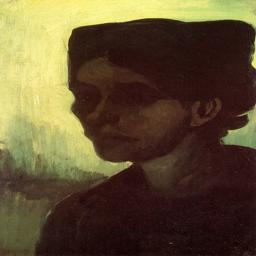

In [ ]:
# Check the First Image and Text in the Dictionary
print(f"Text: {img_prompt['text'][0]}")
display(img_prompt['image'][0])

In [ ]:
# Save the Dictionary as a New Dataset
van_gogh_data = Dataset.from_dict(img_prompt)

In [ ]:
# Check the Dataset
van_gogh_data

Dataset({
    features: ['image', 'text'],
    num_rows: 494
})

In [ ]:
# Save the Dataset
van_gogh_data.save_to_disk('/content/drive/MyDrive/MSAAI - 521 Introduction to Computer Vision/Team 5/Code')

Saving the dataset (0/1 shards):   0%|          | 0/494 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'text'],
    num_rows: 494
})
Head of a Young Peasant Woman with Dark Cap


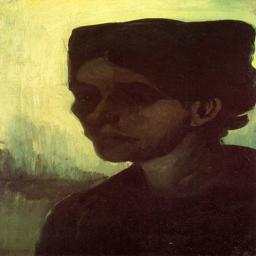

In [ ]:
# Load the Dataset
van_gogh_data = Dataset.load_from_disk('/content/drive/MyDrive/Code')

# Check the Dataset
print(van_gogh_data)

# Print the First Image and Text
print(van_gogh_data[0]['text'])
display(van_gogh_data[0]['image'])

# Model Implementation and Fine-Tuning

In this section the pre-trained model "CompVis/stable-diffusion-v1-4" was fine-tuned by exploiting the "van_gogh_data" created/loaded above. It is interesting to compare the images generated by the model with the same prompt ("Head of a Young Peasant Woman with Dark Cap") before and after fine-tuning. The image after fine-tuning has a more visible van-gogh style, which was absolutely absent in the first image. The final model was saved as "van_gogh_model" to be loaded and reused for testing without running the entire code again, which is very time-consuming.

In [ ]:
# Load the Initial Model
pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe = pipeline.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
# Function to Generate an Image Based on the Received Prompt
def display_prompt(prompt, pipe=pipe):
  '''
  Given a Prompt and Optional Pipeline, Display the Resulting Image
  '''
  display(pipe(prompt).images[0])

  0%|          | 0/50 [00:00<?, ?it/s]

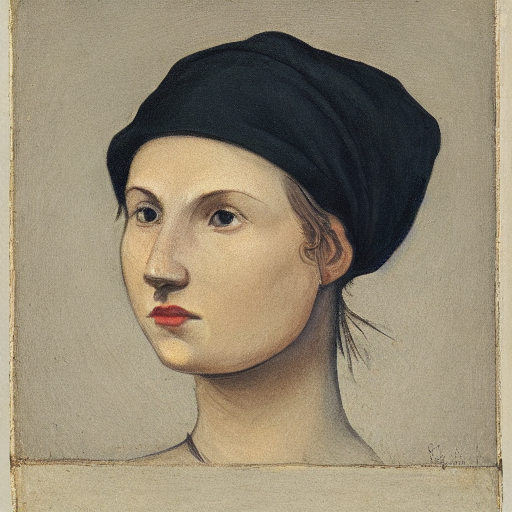

In [ ]:
# Test Initial Model
display_prompt("Head of a Young Peasant Woman with Dark Cap")

In [ ]:
# Train the Model in the Style of Van Gogh
# See: https://huggingface.co/docs/diffusers/v0.13.0/en/training/text2image
!accelerate config default

# Define the Variables
MODEL_NAME="CompVis/stable-diffusion-v1-4"
dataset_name="/content/drive/MyDrive/Code"

# Launch the Training Python Script
!accelerate launch /content/drive/MyDrive/Code/train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$dataset_name \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=900 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="/content/drive/MyDrive/Code/van-gogh-model"

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.
2023-11-26 22:57:08.122617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 22:57:08.122665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 22:57:08.122705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 22:57:09.298369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
11/26/2023 22:57:09 - INFO - __main__ - Distributed environm

In [9]:
# EDIT AND THEN RUN THIS CELL
# Load the Fine Tuned Model
# EDIT: Change Model Path to the Local Path to the Trained Model in your Google Drive
model_path = "/content/drive/MyDrive/Code/van-gogh-model"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16, use_safetensors=True)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.25.0.dev0",
  "_name_or_path": "/content/drive/MyDrive/Code/van-gogh-model",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

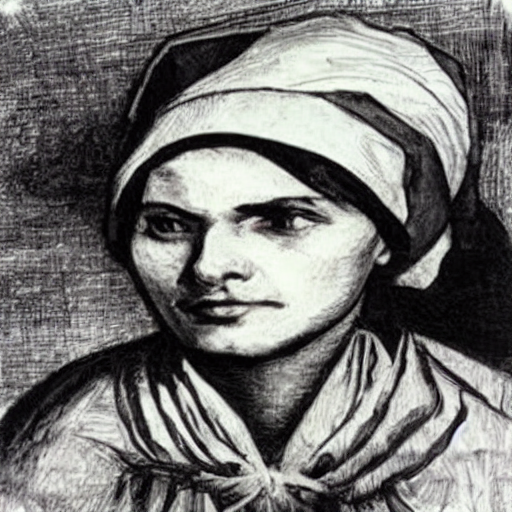

In [ ]:
# Test Tuned Model
display_prompt("Head of a Young Peasant Woman with Dark Cap")

# Evaluate the Model (CLIP Score and FID)

In this section the model is quantitatively evaluated by using two different types of metrics: CLIP score and Fréchet Inception Distanc (FID). The pieces of codes to calculate these two metrics were extracted from Evaluating Diffusion Models (n.d.).

References:
Evaluating Diffusion Models. (n.d.). Hugging Face. https://huggingface.co/docs/diffusers/conceptual/evaluation

## CLIP Score

In [17]:
# RUN EVERYTHING IN THIS SUB-SECTION, DO NOT RUN DEPLOYMENT
# Make the Model Generate Different Types of Images Belonging to Six Different Categories: Cities, Landscapes, Sky, Flowers, Professions, and Situations

cities = [
    "amsterdam",
    "london",
    "paris",
    "new york"]

lanscapes = [
    "countryside",
    "forest",
    "lake",
    "mountains"]

sky = [
    "moonlight",
    "rainbow",
    "snowstorm",
    "sunset"]

flowers = [
    "blue irises",
    "daisies",
    "sunflowers",
    "water lilies"]

professions = [
    "actors",
    "bakers",
    "farmers",
    "fishermen"]

situations = [
    "snowstorm in new york",
    "farmers in the countryside",
    "fishermen in the moonlight",
    "water lilies in the lake",
]

prompts = cities + lanscapes + sky + flowers + professions + situations

generated_images_clip = pipe(prompts, num_images_per_prompt=1, output_type="np").images

print(generated_images_clip.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(24, 512, 512, 3)


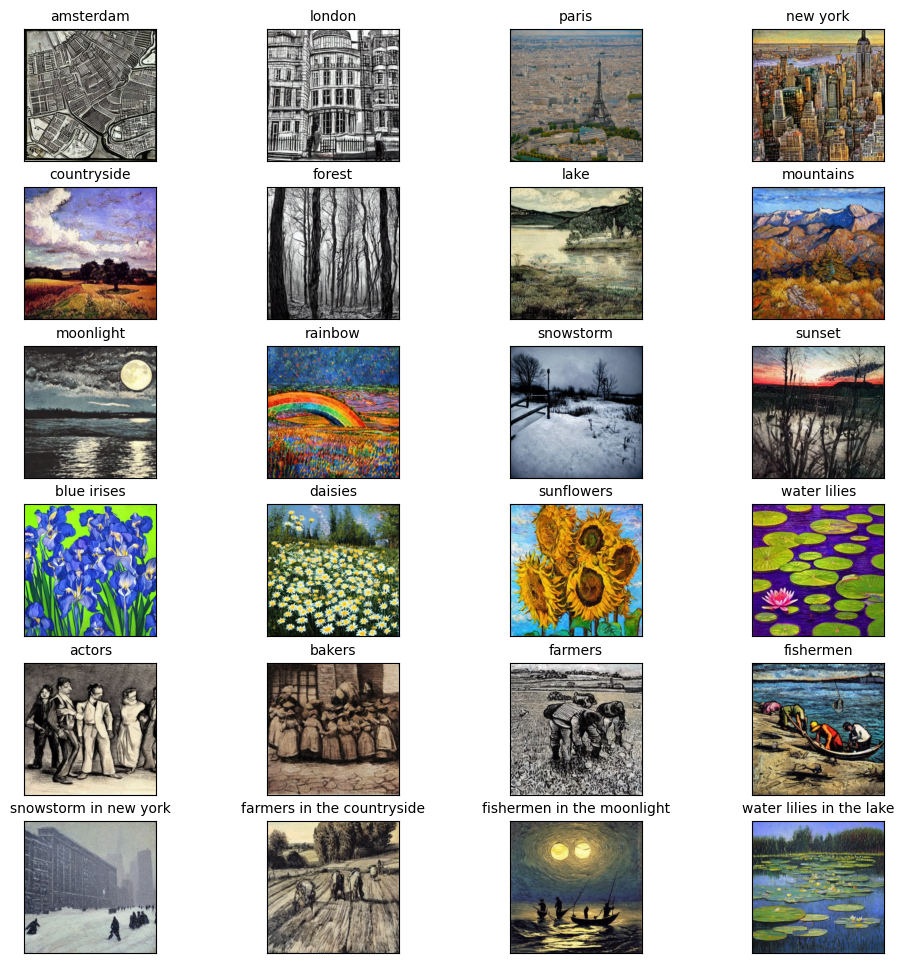

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Plot the Images Generated above for CLIP and Download the Complete Image Panel
fig = plt.figure(figsize = (12, 12))
count = 1
for img in generated_images_clip:
    ax = plt.subplot(6, 4, count)
    ax.imshow(img)
    ax.set_title(prompts[count - 1], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    count += 1
plt.savefig('generated_images_clip.png')
plt.show()

files.download('generated_images_clip.png')

In [19]:
# Evaluating Diffusion Models (n.d.)
# Calculate the Average CLIP Score Based on the Twentyfour Images of Landscapes, Sky, Flowers, Professions, Situations Generated above
clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(image, prompt):
    images_int = (generated_images_clip * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 2)

all_clip_scores = []
for jj in range (len(prompts)):
  all_clip_scores.append(calculate_clip_score(generated_images_clip[jj], prompts[jj]))
avg_clip_score = np.sum(all_clip_scores)/len(prompts)

print(f"Average CLIP Score: {avg_clip_score}")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Average CLIP Score: 28.89


# FID

In [20]:
# RUN EVERYTHING IN THIS SUB-SECTION, DO NOT RUN DEPLOYMENT
# Access other Real Van Gogh images not Included in the van_gogh_data to Fine-Tune the Model in order to Calculate FID
dataset_path = "/content/drive/MyDrive/Code/paintings_van_gogh"
image_paths = sorted([os.path.join(dataset_path, x) for x in os.listdir(dataset_path)])

real_images = [np.array(Image.open(path).convert("RGB")) for path in image_paths]

In [21]:
# Get the Titles of the Real Images
list_of_titles = [
    "a woman walking in the garden",
    "basket of apples",
    "child with orange",
    "cottages",
    "dunes",
    "fisherman on the beach",
    "flowers in a blue vase",
    "girl in the wood",
    "harvest in provence",
    "lying cow",
    "old woman of arles",
    "the potato peeler",
    "the willow",
    "three sunflowers in a vase",
    "view of the roofs of paris",
    "woman sitting in the grass"]

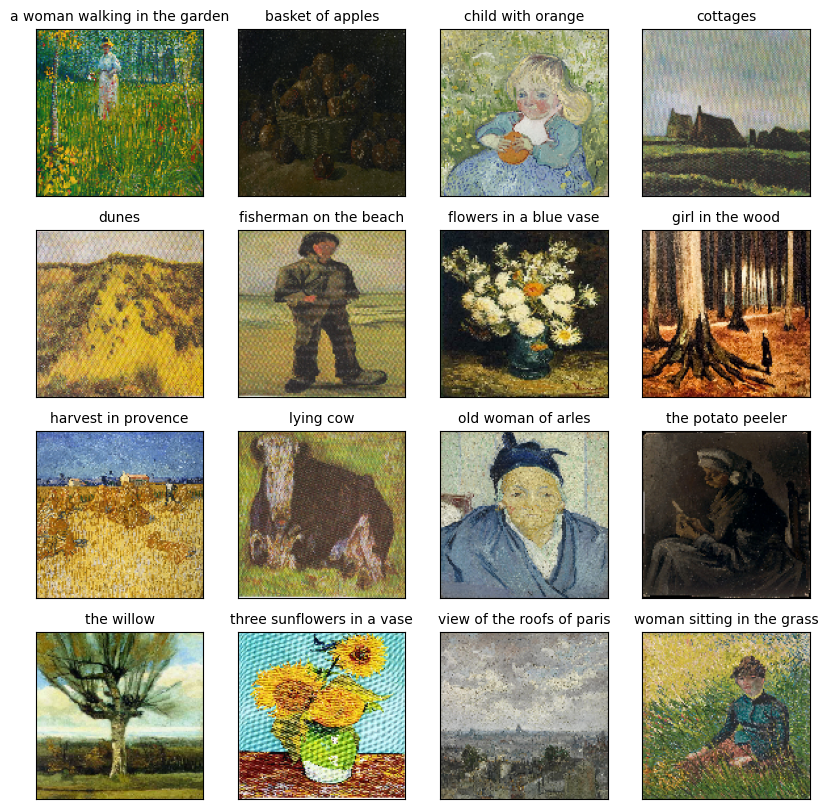

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Plot the Real Images and Download the Complete Image Panel
fig = plt.figure(figsize = (10, 10))
count = 1
for img in real_images:
    ax = plt.subplot(4, 4, count)
    ax.imshow(cv2.resize(img, (128, 128)))
    ax.set_title(list_of_titles[count - 1], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    count += 1
plt.savefig('real_images.png')
plt.show()

files.download('real_images.png')

In [23]:
# Evaluating Diffusion Models (n.d.)
# Function to Preprocess Real Images
def preprocess_image(image):
    image = torch.tensor(image).unsqueeze(0)
    image = image.permute(0, 3, 1, 2) / 255.0
    return F.center_crop(image, (256, 256))

real_images = torch.cat([preprocess_image(img) for img in real_images])
print(real_images.shape)

torch.Size([16, 3, 256, 256])


In [26]:
# Make the Model Generate Images with Prompts Equal to list_of_titles
generated_images_fid = pipe(list_of_titles, num_images_per_prompt=1, output_type="np").images

print(generated_images_fid.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

(16, 512, 512, 3)


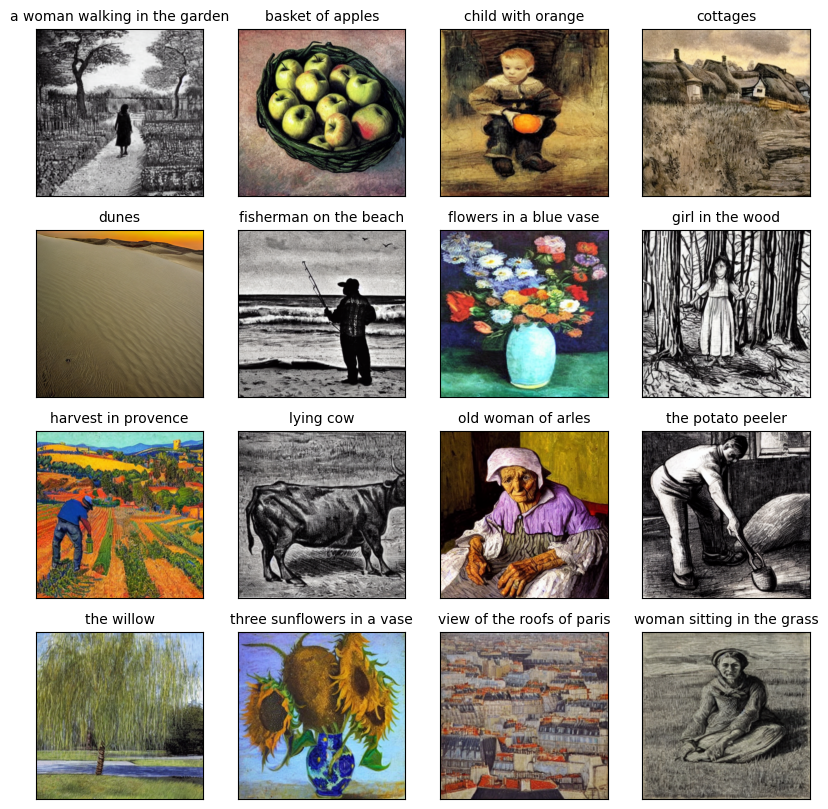

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Plot the Images Generated above for FID and Download the Complete Image Panel
fig = plt.figure(figsize = (10, 10))
count = 1
for img in generated_images_fid:
    ax = plt.subplot(4, 4, count)
    ax.imshow(img)
    ax.set_title(list_of_titles[count - 1], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    count += 1
plt.savefig('generated_images_fid.png')
plt.show()

files.download('generated_images_fid.png')

In [28]:
# Evaluating Diffusion Models (n.d.)
# Preprocess Generated Images for FID as Real Images
generated_images_fid = torch.cat([preprocess_image(img) for img in generated_images_fid])
print(generated_images_fid.shape)

torch.Size([16, 3, 256, 256])


In [29]:
# Evaluating Diffusion Models (n.d.)
# Calculate the FID
FID = FrechetInceptionDistance(normalize=True)
FID.update(real_images, real=True)
FID.update(generated_images_fid, real=False)

print(f"FID: {float(FID.compute())}")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 327MB/s]


FID: 677.1911010742188


## User Metrics

In thi section, we calculated mean value and standard deviation of the five metrics reported in the Google form we prepared based on the results received from 16 users.

In [6]:
relevance_prompt = [4, 4, 5, 4, 5, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5]
vg_style = [5, 3, 5, 5, 5, 5, 1, 2, 5, 3, 5, 3, 4, 2, 5, 5]
complexity = [5, 3, 5, 4, 3, 3, 3, 4, 5, 3, 5, 4, 5, 3, 4, 5]
creativity = [2, 2, 4, 4, 5, 5, 2, 5, 5, 4, 5, 4, 5, 3, 4, 5]
general_satisfaction = [3, 4, 5, 4, 5, 5, 3, 4, 5, 4, 5, 5, 5, 3, 5, 5]

import numpy as np

avg_relevance_prompt = round(np.mean(relevance_prompt),2)
std_relevance_prompt = round(np.std(relevance_prompt),2)
avg_vg_style = round(np.mean(vg_style),2)
std_vg_style = round(np.std(vg_style),2)
avg_complexity = round(np.mean(complexity),2)
std_complexity = round(np.std(complexity),2)
avg_creativity = round(np.mean(creativity),2)
std_creativity = round(np.std(creativity),2)
avg_general_satisfaction = round(np.mean(general_satisfaction),2)
std_general_satisfaction = round(np.std(general_satisfaction),2)

print("Relevance Prompt: ", avg_relevance_prompt, "+/-", std_relevance_prompt)
print("VG Style: ", avg_vg_style, "+/-", std_vg_style)
print("Complexity: ", avg_complexity, "+/-", std_complexity)
print("Creativity: ", avg_creativity, "+/-", std_creativity)
print("General Satisfaction: ", avg_general_satisfaction, "+/-", std_general_satisfaction)

Relevance Prompt:  4.56 +/- 0.7
VG Style:  3.94 +/- 1.34
Complexity:  4.0 +/- 0.87
Creativity:  4.0 +/- 1.12
General Satisfaction:  4.38 +/- 0.78


## Deploy the Model via HuggingFace

Lines of code to deploy the model via HuggingFace.

In [ ]:
## Push the Model to HuggingFace
pipe.push_to_hub("van-gogh-stable-diffusion", )